Unimodality/multimodality tests:

https://github.com/BenjaminDoran/unidip

https://www.kdd.org/kdd2016/subtopic/view/skinny-dip-clustering-in-a-sea-of-noise

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, '../../../../FISH-annotation/fishanno')
import clus, param, autocrop, clus
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
import warnings
warnings.filterwarnings('ignore')
from unidip import UniDip
import unidip.dip as dip
from sklearn.neighbors import KDTree
from skimage import filters
from sklearn.cluster import AffinityPropagation, KMeans
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from unidip import UniDip
import unidip.dip as dip

clustering_params = ['AffinityPropagation', -350]
correctness_threshold = 4
img_height = 300

In [5]:
def get_cluster_correctness(df, correctness_threshold):

    num_centroids = df.shape[0]
    to_return = np.empty([num_centroids, 2])
    for i in range(num_centroids):
        to_return[i] = i
        NN_dist = df['NN_dist'][i]
        if (NN_dist <= correctness_threshold):
            to_return[i][1] = True
        else:
            to_return[i][1] = False
    return to_return

In [7]:
def csv_to_kdt(csv_filepath, img_height):

    ref_df = pd.read_csv(csv_filepath)
    ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()

    for i in range(len(ref_points)):
        point = ref_points[i]
        first_elem = point[0]
        second_elem = img_height - point[1]
        point = np.array([first_elem, second_elem])
        ref_points[i] = point

    ref_kdt = KDTree(ref_points, leaf_size=2, metric='euclidean')   # kdt is a kd tree with all the reference points
    return ref_kdt

In [8]:
def anno_and_ref_to_df(clusters, csv_filepath, img_height):

    ref_kdt = csv_to_kdt(csv_filepath, img_height)
    ref_array = np.asarray(ref_kdt.data)

    centroid_IDs = range(clusters.shape[0])
    column_names = ['centroid_x', 'centroid_y', 'NN_x', 'NN_y', 'NN_dist', 'members']
    to_return = pd.DataFrame(index = centroid_IDs, columns = column_names)

    for i in centroid_IDs:

        to_return['centroid_x'][i] = clusters['centroid_x'][i]
        to_return['centroid_y'][i] = clusters['centroid_y'][i]

        coords = [[to_return['centroid_x'][i], to_return['centroid_y'][i]]]

        dist, ind = ref_kdt.query(coords, k=1)
        index = ind[0][0]
        nearest_neighbor = ref_array[index]

        to_return['NN_x'][i] = nearest_neighbor[0]
        to_return['NN_y'][i] = nearest_neighbor[1]
        to_return['NN_dist'][i] = dist[0][0]
        to_return['members'][i] = clusters['members'][i]		

    return to_return

In [26]:
def plot_annotations_per_cluster(df, clusters, correctness_threshold, csv_filepath, img_filename, plot_title):

        correct_list = []
        incorrect_list = []
        total_list = []
        anno_and_ref_df = anno_and_ref_to_df(clusters, csv_filepath, img_height)
        cluster_correctness = get_cluster_correctness(anno_and_ref_df, correctness_threshold)
        for i in range(len(clusters.index)):
            row = clusters.iloc[[i]]
            members = row.iloc[0]['members']
            worker_list = []
            for member in members:
                worker_list.append(member[3])
            num_members = len(np.unique(worker_list))
            if (cluster_correctness[i][1]):		# if cluster is correct
                correct_list.append(num_members)
            else:
                incorrect_list.append(num_members)
            total_list.append(num_members)
        width = max(correct_list)
        if (max(incorrect_list) > width):
            width = max(incorrect_list)

        fig = plt.figure()

        y,x,_ = plt.hist([correct_list, incorrect_list], bins = np.arange(0,width+4,2)-1, stacked = True, color = ['g','m'])


        # treshold kmeans
        total_array = np.asarray(total_list)
        km = KMeans(n_clusters = 2).fit(total_array.reshape(-1,1))
        cluster_centers = km.cluster_centers_
        threshold_kmeans = (cluster_centers[0][0]+cluster_centers[1][0])/2

        plt.axvline(x=threshold_kmeans, color='b')

        g_patch = mpatches.Patch(color='g', label='clusters near ref spot')
        m_patch = mpatches.Patch(color='m', label='clusters far from any ref spot')
        kmeans_line = Line2D([0],[0], color='b', label='k-means threshold')
        plt.legend(handles=[g_patch, m_patch, kmeans_line])

        plt.xlabel("Number of unique workers annotating")
        plt.xticks(np.arange(0,width+2,step=2))
        plt.ylabel("Number of clusters")
        ymin, ymax = plt.ylim()
        if(ymax < 30):
            plt.yticks(np.arange(0,ymax+1,step=3))
        plt.title(plot_title)
        plt.show()

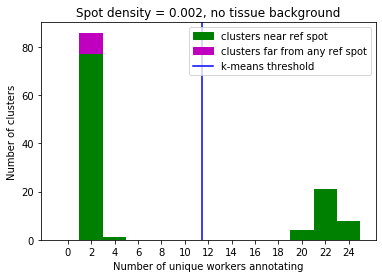

p = 0.000999000999000999


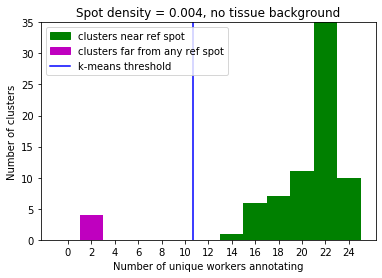

p = 0.08891108891108891


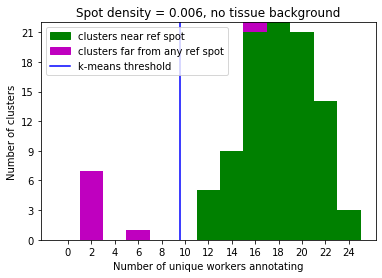

p = 0.8041958041958042


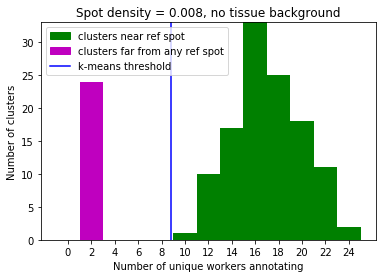

p = 0.41358641358641357


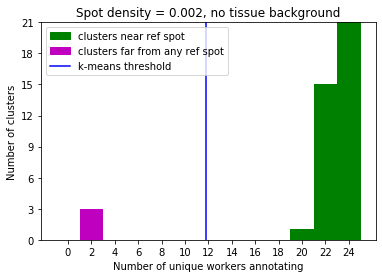

p = 0.025974025974025976


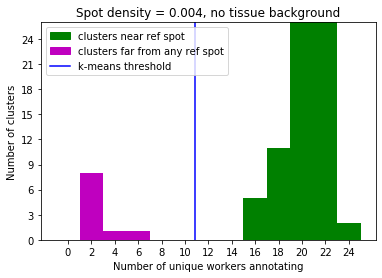

p = 0.2817182817182817


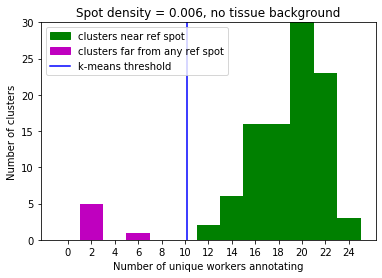

p = 0.3926073926073926


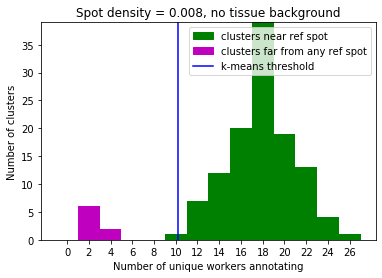

p = 0.26073926073926074


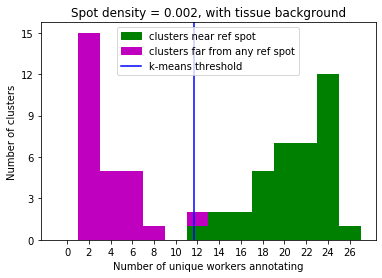

p = 0.007992007992007992


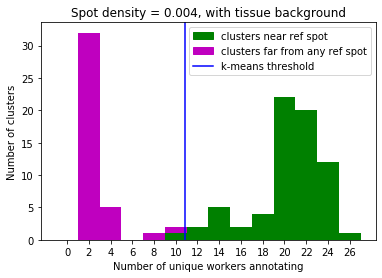

p = 0.001998001998001998


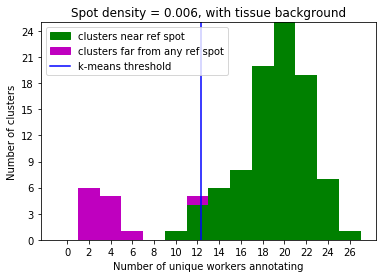

p = 0.5044955044955045


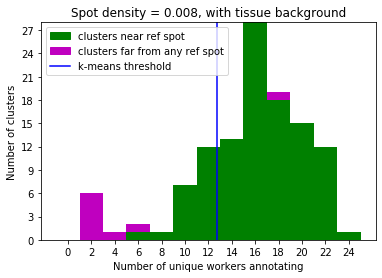

p = 0.4785214785214785


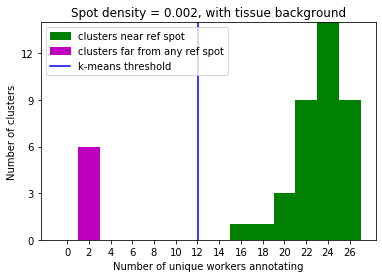

p = 0.32867132867132864


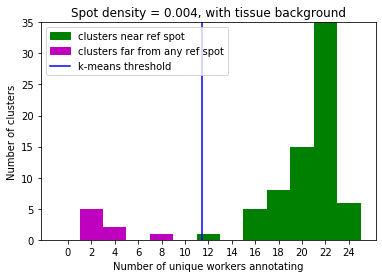

p = 0.04995004995004995


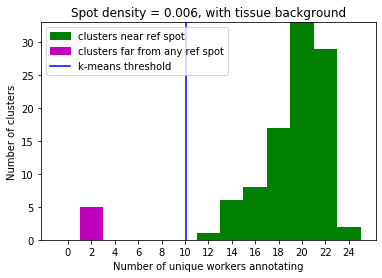

p = 0.18281718281718282


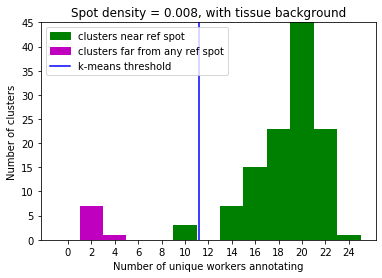

p = 0.3166833166833167


In [31]:
json_filename_list = ['Spots_density_no_tissue.json','Spot_density.json']
density_list = [0.002, 0.004, 0.006, 0.008]
snr_mu_list = [5, 10]
TPR_list_no_tissue = []
FPR_list_no_tissue = []
TPR_list_with_tissue = []
FPR_list_with_tissue = []
for json_filename in json_filename_list:
    for snr_mu in snr_mu_list:
        for density in density_list:
            img_name = 'snr_' + str(snr_mu)+ '_0_density_' + str(density)
            if (json_filename == 'Spots_density_no_tissue.json'):
                img_filename = img_name+'_spots.png'
                img_filepath = './spot_arrays/' + img_filename
            else:
                img_filename = img_name+'_spot_img.png'
                img_filepath = './spot_images/' + img_filename
            csv_filepath = './spot_data/'+img_name+'_coord_snr_list.csv'
            json_filepath = json_filename

            qa = QuantiusAnnotation(json_filepath, img_filename)
            sa = SpotAnnotationAnalysis(qa)
            anno_all = qa.df()
            
            plot_title = "Spot density = " + str(density) + ", "
            if (json_filename == 'Spots_density_no_tissue.json'):
                plot_title += 'no tissue background'
            else:
                plot_title += 'with tissue background'
                
            clusters = sa.get_clusters(anno_all, clustering_params)

            plot_annotations_per_cluster(anno_all, clusters, correctness_threshold, csv_filepath, img_filename, plot_title)
            
            total_list = []
            for i in range(len(clusters.index)):
                row = clusters.iloc[[i]]
                members = row.iloc[0]['members']
                worker_list = [member[3] for member in members]
                num_members = len(np.unique(worker_list))
                total_list.append(num_members)
            
            data = np.msort(total_list)
            dip_test_p_value = dip.diptst(data)[1]
            print('p = ' + str(dip_test_p_value))
            
            
            